<a href="https://colab.research.google.com/gist/Anacrishc/e3f79579d1377ced0defdc3eacf081c8/datamining_aves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Mining - Práctica Clasificación de vocalizaciones de ave**
- - -


##Librerias

In [ ]:
import glob as glob
import pandas as pd
import librosa
import IPython.display as ipd
import librosa.display
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import time
import progressbar
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D,InputLayer
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


##Analisis de datos


###Analisis de ficheros de texto

Realizamos la carga de los ficheros .txt en una lista

In [ ]:
text_files = glob.glob('/content/drive/MyDrive/Data_Mining/audios_files/*/*.txt')
text_files.sort()


In [ ]:
print(text_files)
len(text_files)

['/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC417157.txt', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC417158.txt', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC417425.txt', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC417722.txt', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC419606.txt', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC420352.txt', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC420542.txt', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC422018.txt', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC422019.txt', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC422797.txt', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC428977.txt', '/content

879

Realizamos el procesamiento de los archivos .txt a un dataframe

In [ ]:
list_data = []
colnames=['Time_Begin', 'Time_End', 'Type_Sound']
i=0

bar = progressbar.ProgressBar(max_value=progressbar.UnknownLength)

for filename in text_files:
  data = pd.read_csv(filename,sep="\t",header=None,names=colnames)
  data["Time_Duration"] = round(data["Time_End"]-data["Time_Begin"],6)
  data['Log_Time_Duration'] = np.log(data['Time_Duration'])
  data["Specie"] = filename[48:].split(sep="/")[0]
  data["Archive_txt"] = filename[48:].split(sep="/")[1]
  list_data.append(data)
  i=i+1
  bar.update(i)

\ |  #                                              | 879 Elapsed Time: 0:06:31

In [ ]:
##Cargamos la lista en un dataframe
df=pd.concat(list_data,ignore_index=True)

In [ ]:
df.head()

Time_Begin   Time_End Type_Sound  Time_Duration  Log_Time_Duration  \
0    2.168366   5.108297       song       2.939931           1.078386   
1   19.289143  20.885486       song       1.596343           0.467715   
2    3.496018   5.093184       song       1.597166           0.468231   
3    9.991159  13.149998       song       3.158839           1.150205   
4   18.651346  21.277797       song       2.626451           0.965634   

                      Specie   Archive_txt  
0  Acrocephalus arundinaceus  XC417157.txt  
1  Acrocephalus arundinaceus  XC417157.txt  
2  Acrocephalus arundinaceus  XC417158.txt  
3  Acrocephalus arundinaceus  XC417158.txt  
4  Acrocephalus arundinaceus  XC417158.txt

Realizamos un grafico de barras, en el cual verificamos la cantidad de segundos por cada especie registrada

In [ ]:
px.bar(df.groupby('Specie')['Time_Duration'].sum().sort_values(ascending=False).reset_index(), x="Specie", y="Time_Duration", color="Specie")

Realizamos un grafico boxplot con nuestros valores duracion en funcion logaritmicas para ver mejor los detalles de los valores pequeños y grandes. Con este tipo de grafico podremos verificar valores atipicos y entender como se distribuye los datos

<AxesSubplot:xlabel='Specie', ylabel='Log_Time_Duration'>

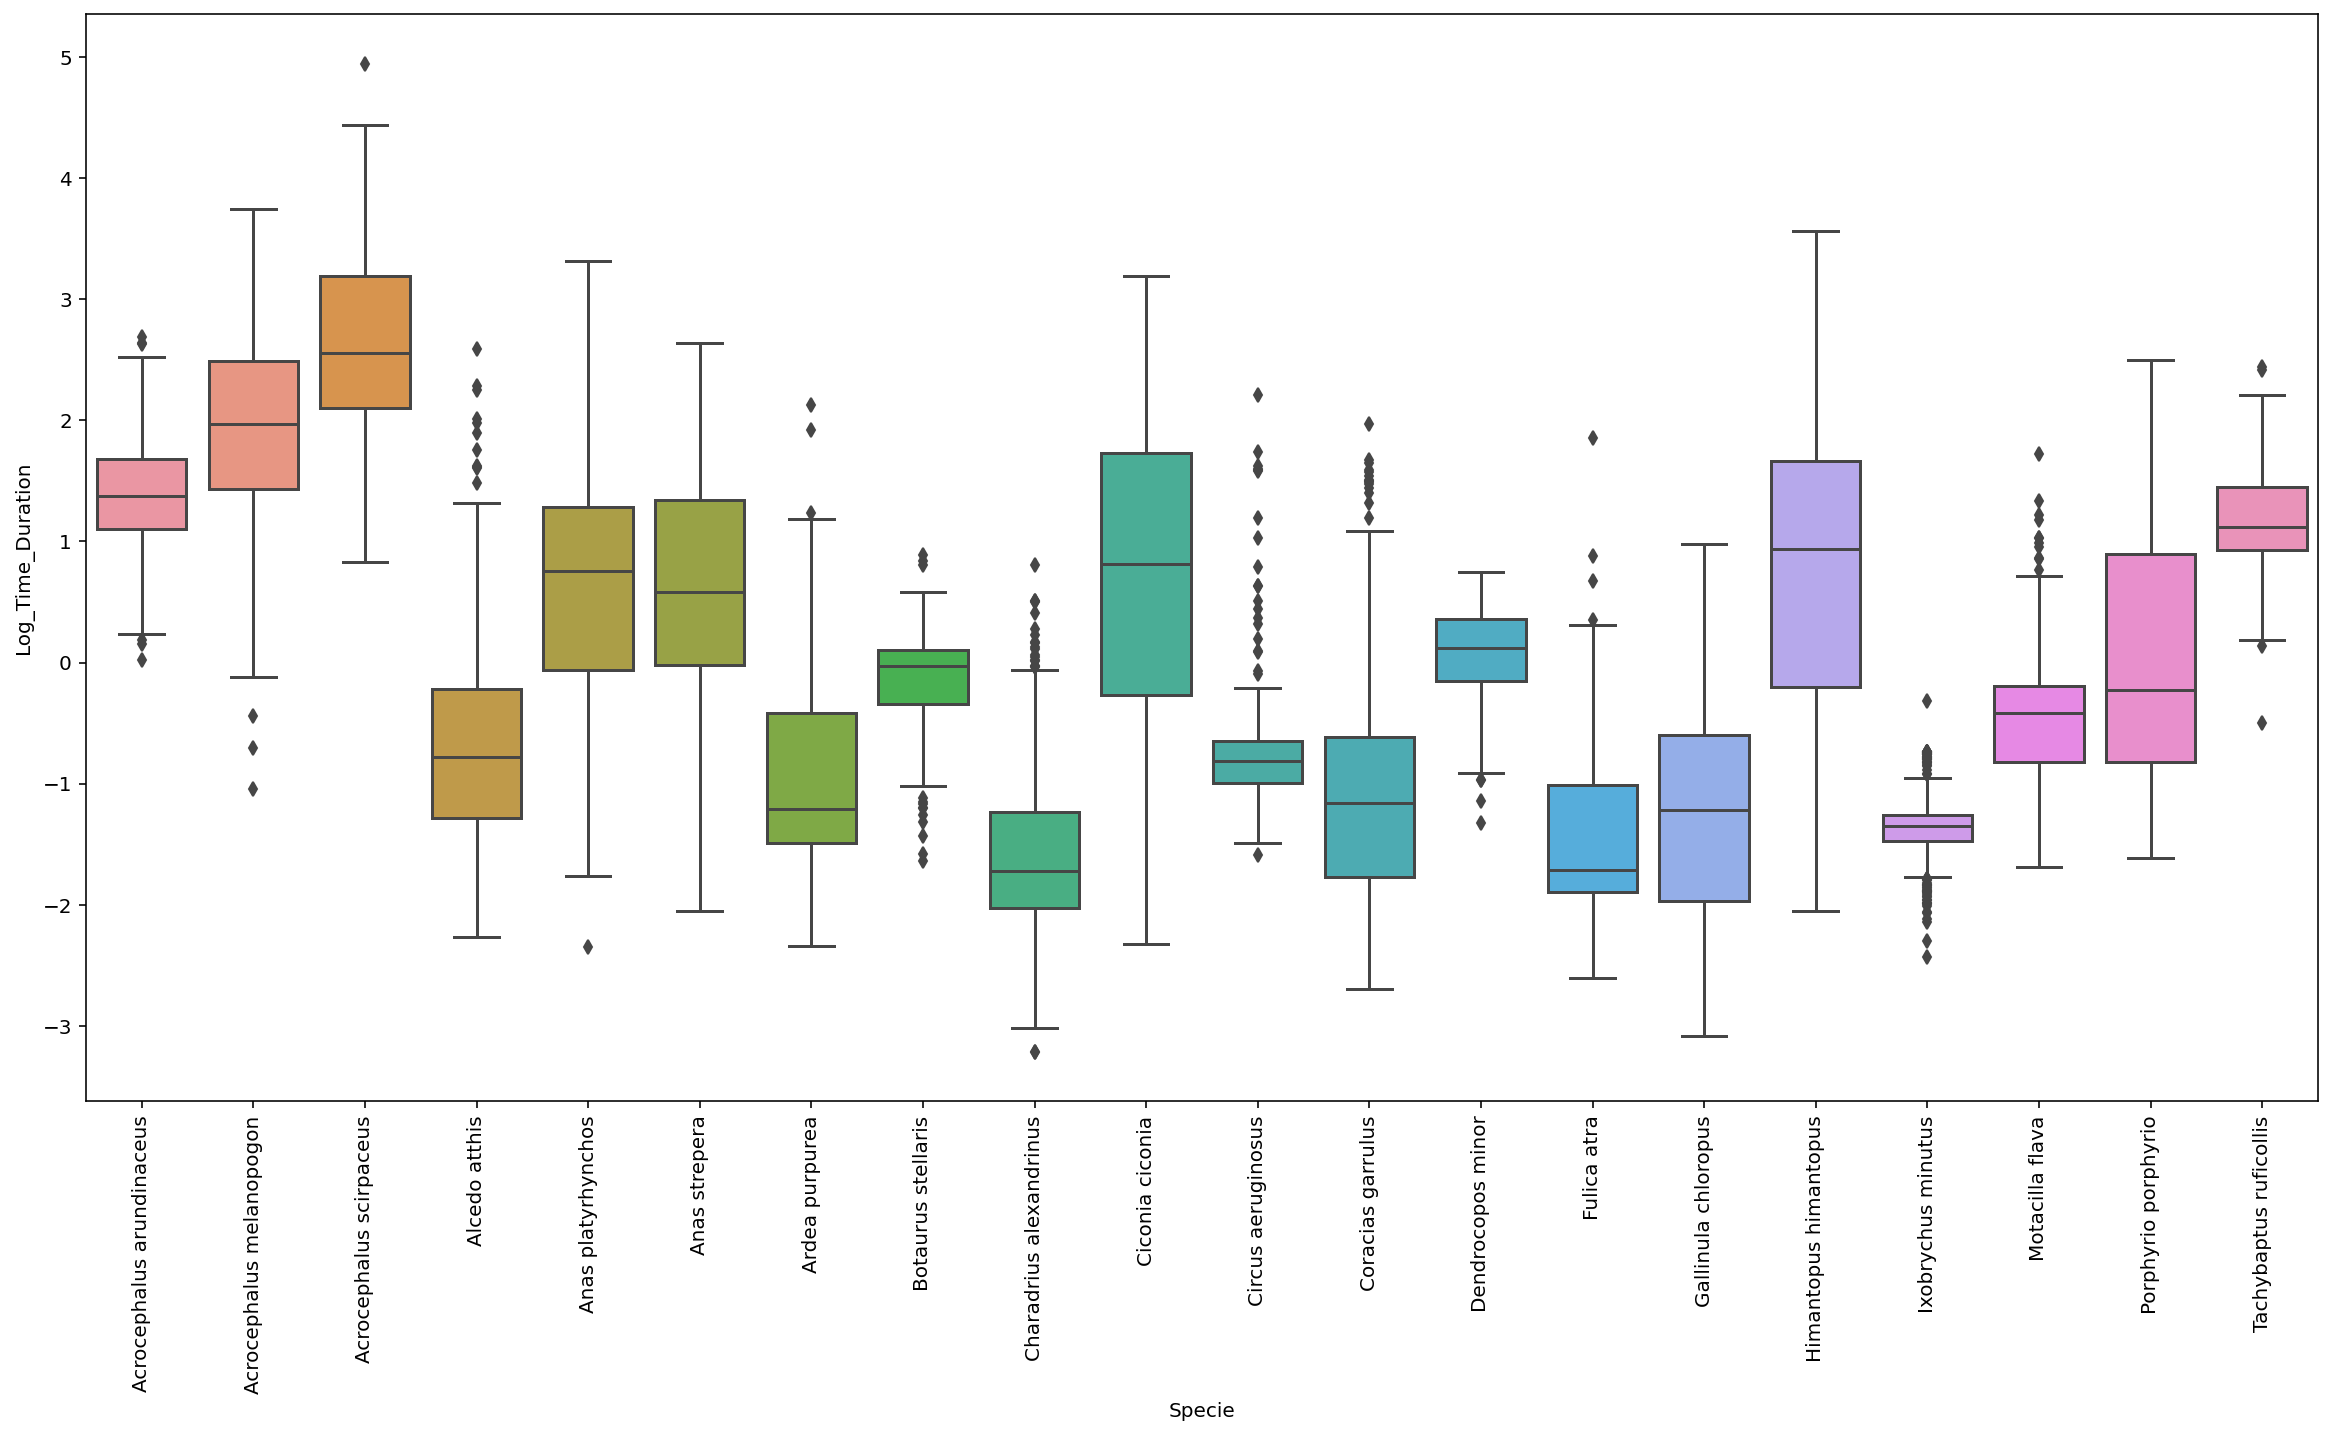

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
sns.boxplot(x='Specie', y='Log_Time_Duration', data=df)

<AxesSubplot:xlabel='Specie', ylabel='Log_Time_Duration'>

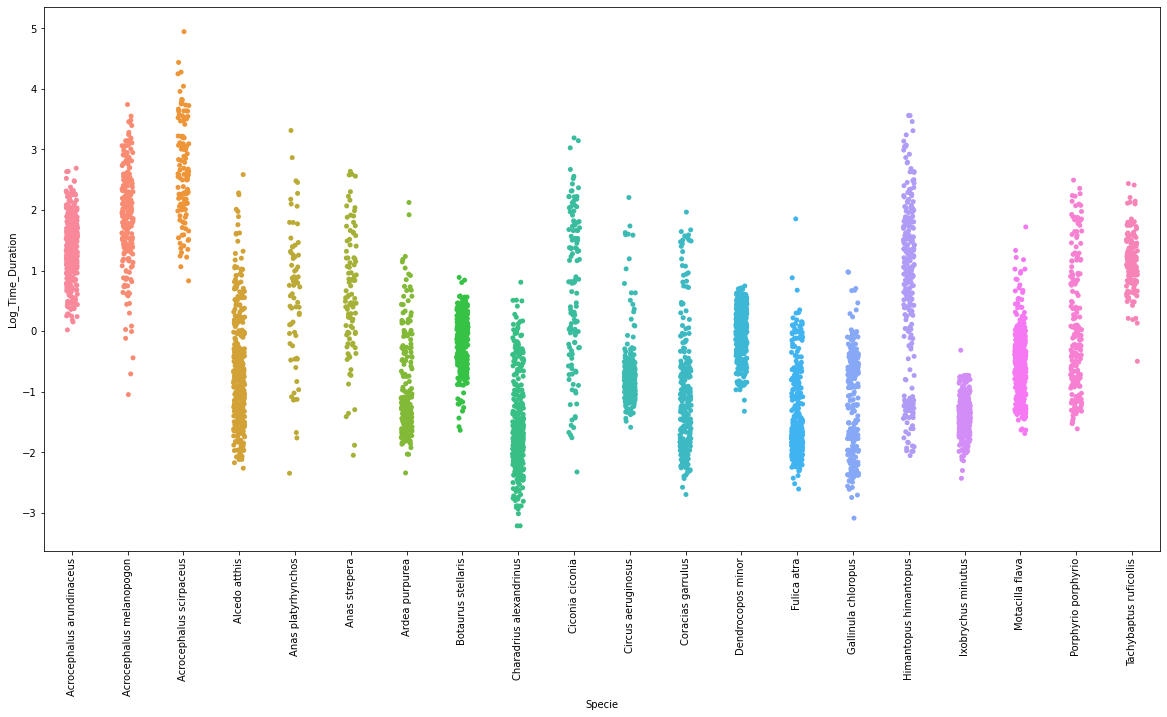

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
sns.stripplot(x="Specie", y="Log_Time_Duration", data=df)

###Analisis de ficheros de audio

Realizamos la carga de los ficheros de audio en una lista

In [ ]:
##Leemos los ficheros audios de la informacion recopilada de los audios en Drive
audio_files_1 = glob.glob('/content/drive/MyDrive/Data_Mining/audios_files/*/*.mp3')
audio_files_2 = glob.glob('/content/drive/MyDrive/Data_Mining/audios_files/*/*.MP3')
audio_files=audio_files_1+audio_files_2
audio_files.sort()

In [ ]:
##Verificamos los archivos cargados
print(audio_files)
len(audio_files)

['/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC417157.mp3', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC417158.mp3', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC417425.mp3', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC417722.mp3', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC419606.mp3', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC420352.mp3', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC420542.mp3', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC422018.mp3', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC422019.mp3', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC422797.mp3', '/content/drive/MyDrive/Data_Mining/audios_files/Acrocephalus arundinaceus/XC428977.mp3', '/content

879

Verificamos uno de los audios para verificar la carga si se realizo correctamente

In [ ]:
ipd.Audio(audio_files[1])

In [ ]:
# 1. Preprocesamiento del audio
audio, sr = librosa.load(audio_files[1])
audio_features = librosa.feature.mfcc(y=audio, sr=sr)
features = np.mean(audio_features, axis=1)
features

array([-3.9694345e+02,  3.6772591e+01, -3.7858330e+01,  2.6893929e+01,
       -1.8473745e+01,  3.4106658e+00, -1.4156942e+00, -3.0066603e-01,
       -5.2213687e-01,  4.8023782e+00, -1.1525564e+01,  1.0041857e+01,
       -1.1280059e+01,  7.3785412e-01, -1.6172156e-01,  1.8631182e+00,
       -2.7193260e+00,  6.5926542e+00, -7.0583057e+00,  5.6267505e+00],
      dtype=float32)

Utilizaremos este grafico para verificar la forma de la onda de la amplitud vs
tiempo

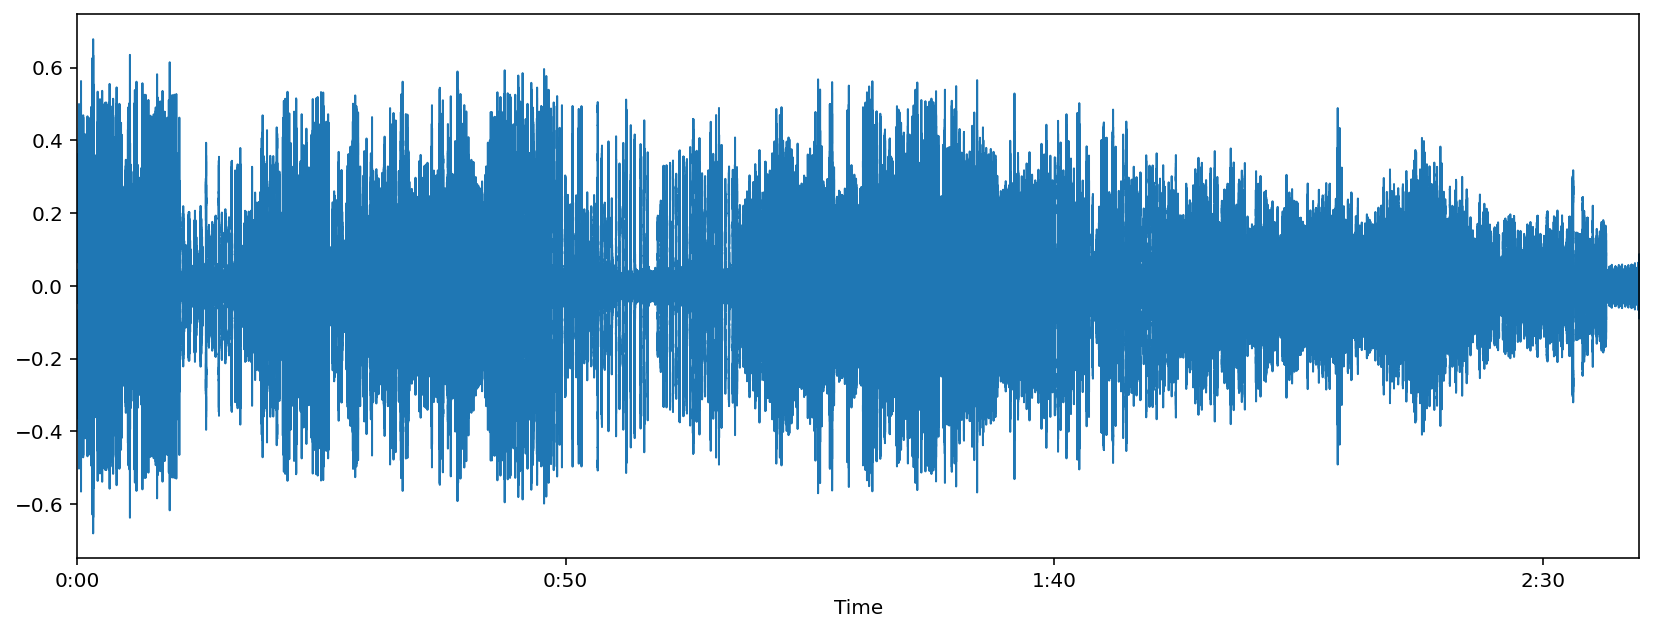

In [ ]:
audio_path = audio_files[1]
x , sr = librosa.load(audio_path)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

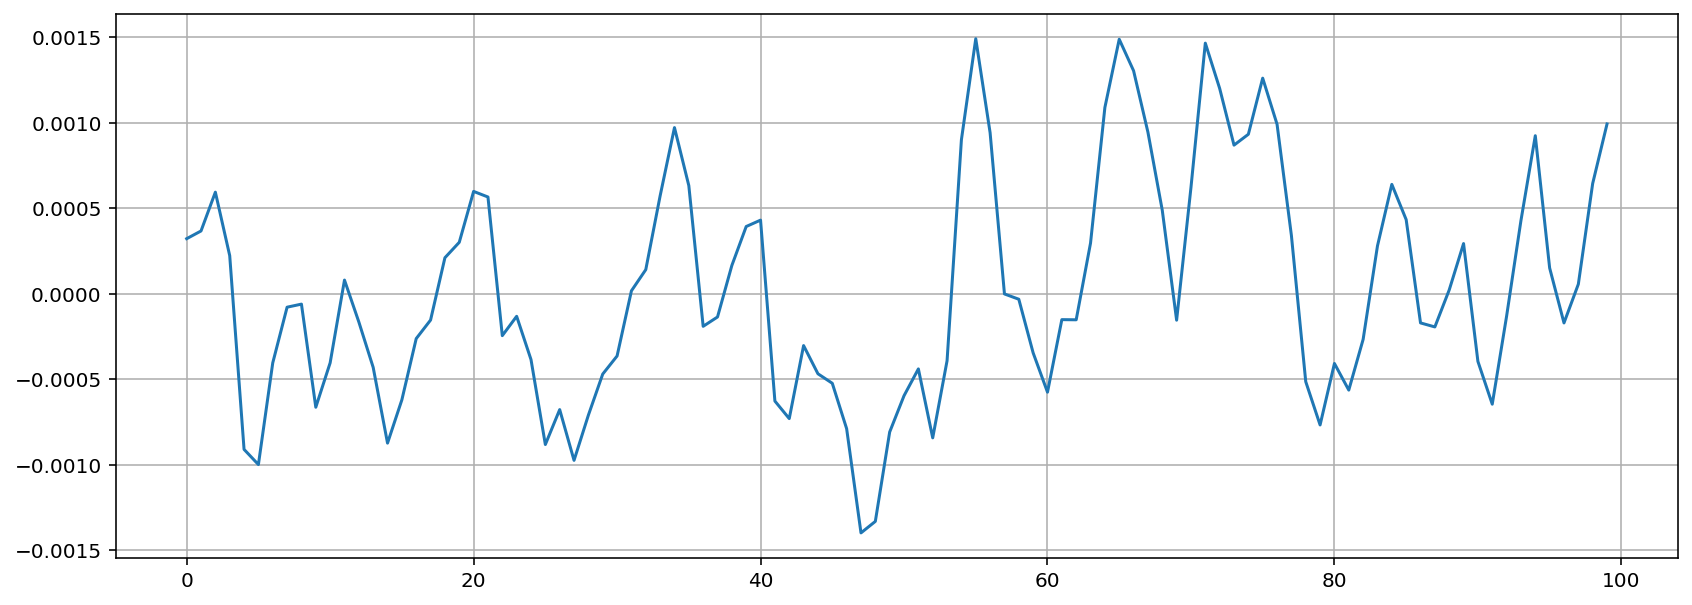

In [ ]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

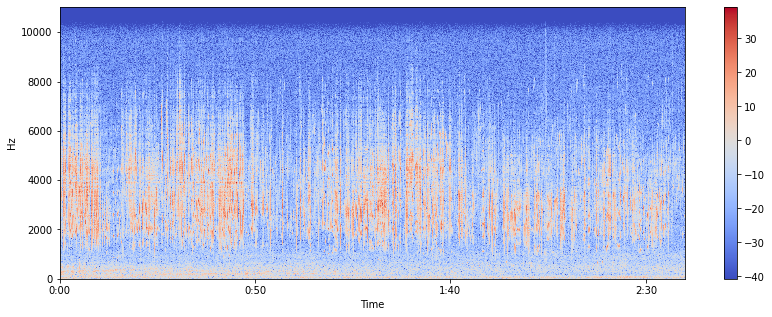

In [ ]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

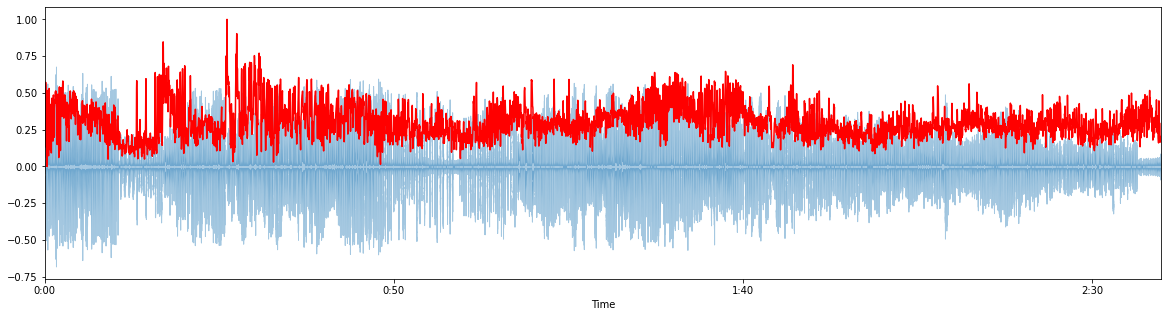

In [ ]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
plt.figure(figsize=(20, 5))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

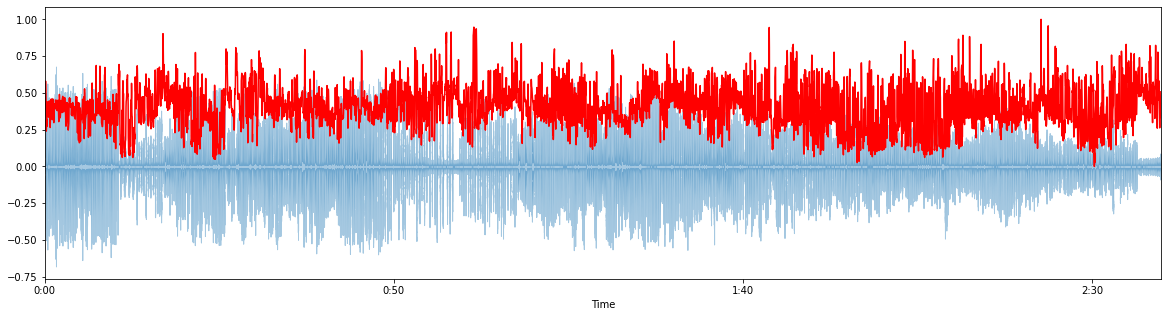

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
plt.figure(figsize=(20, 5))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

(20, 6886)


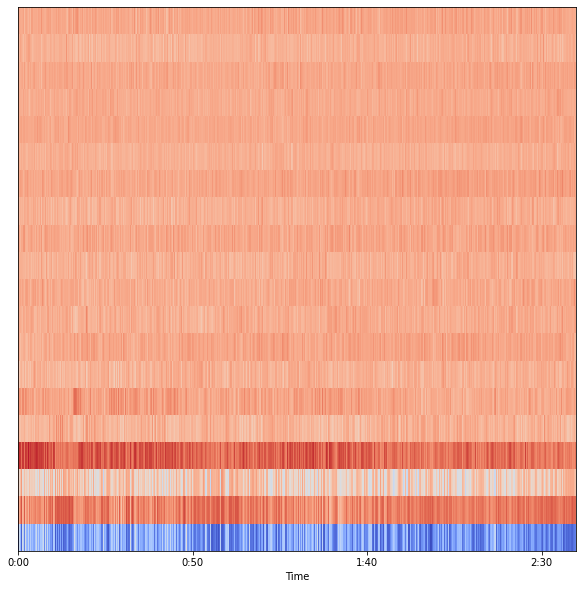

In [ ]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
plt.figure(figsize=(10, 10))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

###Analisis de ficheros de espectrogramas

Realizamos la carga de los ficheros de espectrogramas en una lista

In [ ]:
spectrograms_files = glob.glob('/content/drive/MyDrive/Data_Mining/spectrograms/*/*.npy')
spectrograms_files.sort()

In [ ]:
##Verificamos los archivos cargados
print(spectrograms_files)
len(spectrograms_files)

['/content/drive/MyDrive/Data_Mining/spectrograms/Acrocephalus arundinaceus/XC417157_0.npy', '/content/drive/MyDrive/Data_Mining/spectrograms/Acrocephalus arundinaceus/XC417157_1.npy', '/content/drive/MyDrive/Data_Mining/spectrograms/Acrocephalus arundinaceus/XC417157_2.npy', '/content/drive/MyDrive/Data_Mining/spectrograms/Acrocephalus arundinaceus/XC417157_3.npy', '/content/drive/MyDrive/Data_Mining/spectrograms/Acrocephalus arundinaceus/XC417157_4.npy', '/content/drive/MyDrive/Data_Mining/spectrograms/Acrocephalus arundinaceus/XC417157_5.npy', '/content/drive/MyDrive/Data_Mining/spectrograms/Acrocephalus arundinaceus/XC417158_0.npy', '/content/drive/MyDrive/Data_Mining/spectrograms/Acrocephalus arundinaceus/XC417158_1.npy', '/content/drive/MyDrive/Data_Mining/spectrograms/Acrocephalus arundinaceus/XC417158_10.npy', '/content/drive/MyDrive/Data_Mining/spectrograms/Acrocephalus arundinaceus/XC417158_11.npy', '/content/drive/MyDrive/Data_Mining/spectrograms/Acrocephalus arundinaceus/XC

17406

Debido a temas computacionales con el Colab se procede a almacenar por partes en una lista , posteriormente se graba en un archivo .pkl, para solo leer este archivo ligero y evitar realizar la carga de los espectrogramas que en la mayoria de ocasiones ocasiona crasheo,lentitud en su carga

In [ ]:
list_data = []
i=0
bar = progressbar.ProgressBar(max_value=len(spectrograms_files))

for filename in spectrograms_files:
  data_array = np.load(filename)
  fila = []
  for f in data_array:
    fila.extend(f)
  data = pd.DataFrame(fila)
  data = data.transpose()
  data["Specie"] = filename[48:].split(sep="/")[0]
  data["Archive_npy"] = filename[48:].split(sep="/")[1]
  list_data.append(data)
  i=i+1
  bar.update(i)

In [ ]:
##df_spectro_1=pd.concat(list_data,ignore_index=True)
##df_spectro_1.to_pickle('/content/drive/MyDrive/Data_Mining/df_spectro_1.pkl')
##df_spectro_2=pd.concat(list_data,ignore_index=True)
##df_spectro_2.to_pickle('/content/drive/MyDrive/Data_Mining/df_spectro_2.pkl')
##df_spectro_3=pd.concat(list_data,ignore_index=True)
##df_spectro_3.to_pickle('/content/drive/MyDrive/Data_Mining/df_spectro_3.pkl')
##df_spectro_1= pd.read_pickle('/content/drive/MyDrive/Data_Mining/df_spectro_1.pkl')
##df_spectro_2= pd.read_pickle('/content/drive/MyDrive/Data_Mining/df_spectro_2.pkl')
##df_spectro_3= pd.read_pickle('/content/drive/MyDrive/Data_Mining/df_spectro_3.pkl')
##df_spectro = pd.concat([df_spectro_1, df_spectro_2,df_spectro_3])
##df_spectro=df_spectro.drop_duplicates()

In [ ]:
##df_spectro.to_pickle('/content/drive/MyDrive/Data_Mining/df_spectro.pkl')
df_spectro= pd.read_pickle('/content/drive/MyDrive/Data_Mining/df_spectro.pkl')
df_spectro=df_spectro.reset_index(drop=True)
df_spectro["Archive_txt"] = df_spectro["Archive_npy"].str.split('_').str[0]+".txt"

df_species=df_spectro['Specie'].drop_duplicates().reset_index()
list_values=[]
list_values=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
df_species['value']=list_values

df_spectro=pd.merge(df_spectro,df_species[['Specie','value']],on='Specie')

In [ ]:
shuffle(df_spectro).head()

0          1          2          3          4          5  \
7953  -16.820534 -19.099331 -32.595062 -35.712006 -36.439178 -39.647575   
14138 -36.427776 -38.609360 -52.933350 -50.195030 -51.915676 -56.528145   
3192  -23.648130 -25.944794 -34.243500 -37.215500 -31.668444 -40.432152   
12995 -21.922264 -24.241688 -37.248131 -47.446907 -55.190590 -54.233490   
9059  -17.812834 -20.217823 -40.945110 -46.988586 -42.630600 -42.497593   

               6          7          8          9  ...      50170      50171  \
7953  -50.713196 -36.169193 -34.147652 -34.083836  ... -60.404423 -58.343689   
14138 -61.522121 -74.915665 -57.784256 -52.614441  ... -66.551819 -67.983414   
3192  -30.266611 -33.527832 -30.352953 -31.747046  ... -55.935944 -46.636940   
12995 -49.520828 -46.219200 -49.175629 -46.800552  ... -60.417465 -54.270508   
9059  -34.555511 -40.671192 -37.212482 -42.474873  ... -57.538845 -53.484631   

           50172      50173      50174      50175                    Specie  \
7953  -57.880669 -33.917347 -26.278538 -23.043159   Acrocephalus scirpaceus   
14138 -68.265930 -76.945923 -62.307964 -27.679337     Himantopus himantopus   
3192  -49.470551 -53.896400 -52.424316 -50.307076  Acrocephalus melanopogon   
12995 -52.005486 -54.020607 -61.613869 -58.405487               Fulica atra   
9059  -57.546608 -46.829929 -38.826080 -35.451408    Anas (Mareca) strepera   

            Archive_npy   Archive_txt  value  
7953   XC511697_165.npy  XC511697.txt      2  
14138   XC374912_10.npy  XC374912.txt     15  
3192    XC310529_15.npy  XC310529.txt      1  
12995    XC459669_2.npy  XC459669.txt     13  
9059    XC364458_15.npy  XC364458.txt      4  

[5 rows x 50180 columns]

In [ ]:
df_spectro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17406 entries, 0 to 17405
Columns: 50180 entries, 0 to value
dtypes: float32(50176), int64(1), object(3)
memory usage: 3.3+ GB


Verificamos el balanceo del target

<AxesSubplot:xlabel='Specie', ylabel='count'>

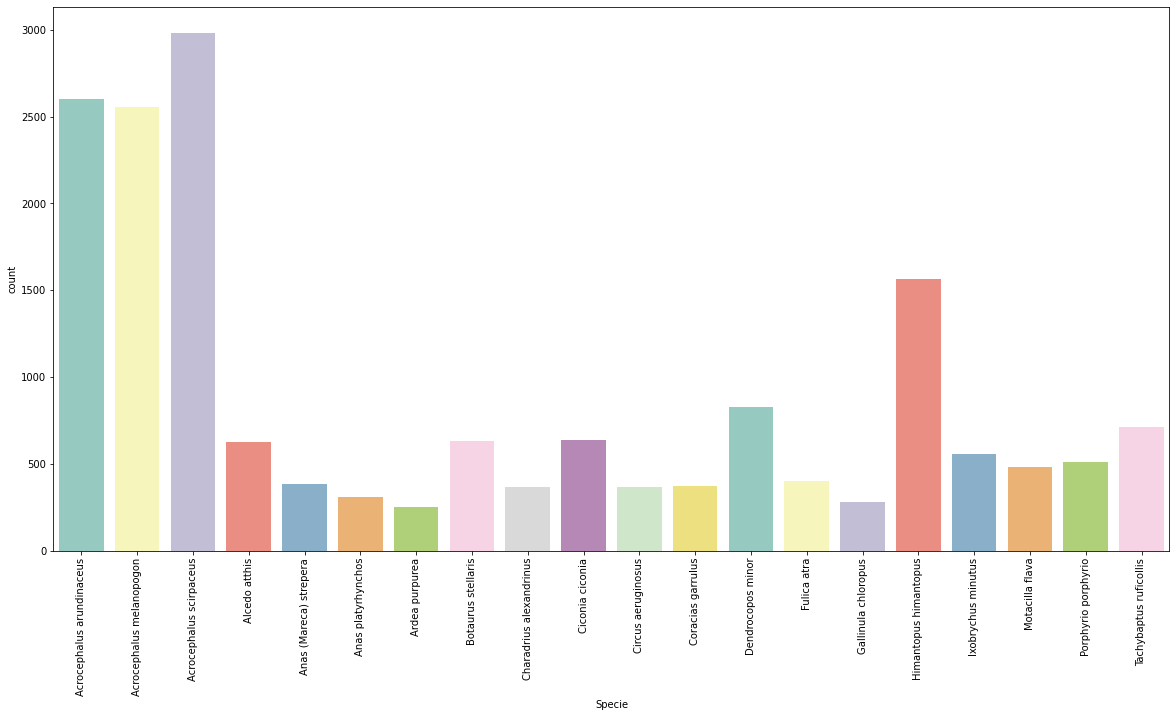

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
sns.countplot(x="Specie", data=df_spectro, palette="Set3",)

##Datos de training & test

Se verifica que en los espectrogramas, cada audio esta dividido en "x" partes, por lo que se considero, que las "X" partes del audio deben estar en un mismo conjunto,sea en Training o Test.Utilizaremos el dataframe de los ficheros TXT como base para sobre este realizar la division entre Train y Test.
En el valor particion podemos escoger si queremos dividir los datos entre "n" numero. Se realizó por temas de capacidad computacional

In [ ]:
df_new=df[['Specie','Archive_txt']].drop_duplicates()

particion=1
list_data=[]
for name_specie in df_new['Specie'].drop_duplicates():
  value = df_new['Specie'][(df_new.Specie==name_specie)].aggregate('count')
  value = round(value/particion)
  df_ramdom=shuffle(df_new[(df_new.Specie==name_specie)]).head(n=value)
  list_data.append(df_ramdom)

df_train_test=pd.concat(list_data,ignore_index=True)

X=df_train_test['Archive_txt']
y=df_train_test['Specie']

In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.3, random_state=200)

Realizamos un join entre el nuevo dataframe de train/test contra los espectrogramas para obtener finalmente nuestros datos de training y test correctamente agrupados

In [ ]:
train=pd.merge(df_spectro,X_train_,on='Archive_txt')
X_train=train.iloc[:, 0:50176]
y_train=train["Specie"]
test=pd.merge(df_spectro,X_test_,on='Archive_txt')
X_test=test.iloc[:, 0:50176]
y_test=test["Specie"]

In [ ]:
y_train_2=train["value"]
y_test_2=test["value"]

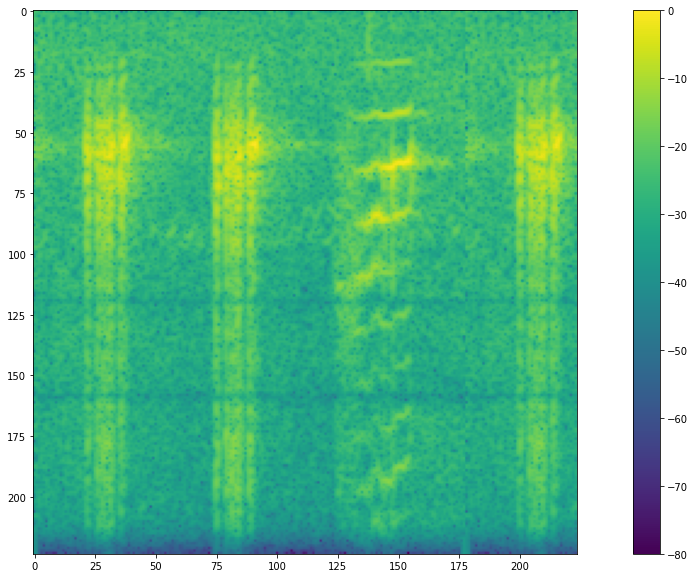

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(np.reshape(X_train.values[1], (224,224)));
plt.colorbar();

In [ ]:
X_train.shape

(12254, 50176)

In [ ]:
X_test.shape

(5152, 50176)

Le damos un reshape para nuestros modelos de Deep Learning y lo almacenamos en variables X_train_2,X_test_2

In [ ]:
X_train_2 = X_train.values.reshape(X_train.shape[0],224,224,1)
X_train_2.shape

(12254, 224, 224, 1)

In [ ]:
X_test_2 = X_test.values.reshape(X_test.shape[0],224,224,1)
X_test_2.shape

(5152, 224, 224, 1)

In [ ]:
# Normalizacion para mddelos de Machile Learning
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
# Normalizacion para modelos de Deep Learning
X_train_2 = X_train_2/255.0
X_test_2 = X_test_2/255.0

##Algoritmos de Machine Learning

###Modelo de Ramdom Forest - Emsemble

In [ ]:
model_RF = RandomForestClassifier()
model_RF.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_test_rf = model_RF.predict(X_test)

In [ ]:
print("Accuracy Score:", round(accuracy_score(y_test, y_test_rf),2))

Accuracy Score: 0.46


In [ ]:
print(classification_report(y_test_rf,y_test))

                           precision    recall  f1-score   support

Acrocephalus arundinaceus       0.45      0.42      0.43       818
 Acrocephalus melanopogon       0.42      0.40      0.41      1020
  Acrocephalus scirpaceus       0.52      0.27      0.36      1281
            Alcedo atthis       0.76      0.64      0.70       170
   Anas (Mareca) strepera       0.18      0.17      0.18        69
       Anas platyrhynchos       0.14      0.17      0.15        46
           Ardea purpurea       0.17      0.26      0.21        38
       Botaurus stellaris       1.00      0.98      0.99       184
  Charadrius alexandrinus       0.02      0.31      0.05        13
          Ciconia ciconia       0.70      0.59      0.64       168
       Circus aeruginosus       0.08      0.28      0.12        25
        Coracias garrulus       0.26      0.26      0.26        69
        Dendrocopos minor       0.75      0.68      0.71       280
              Fulica atra       0.09      0.33      0.14     

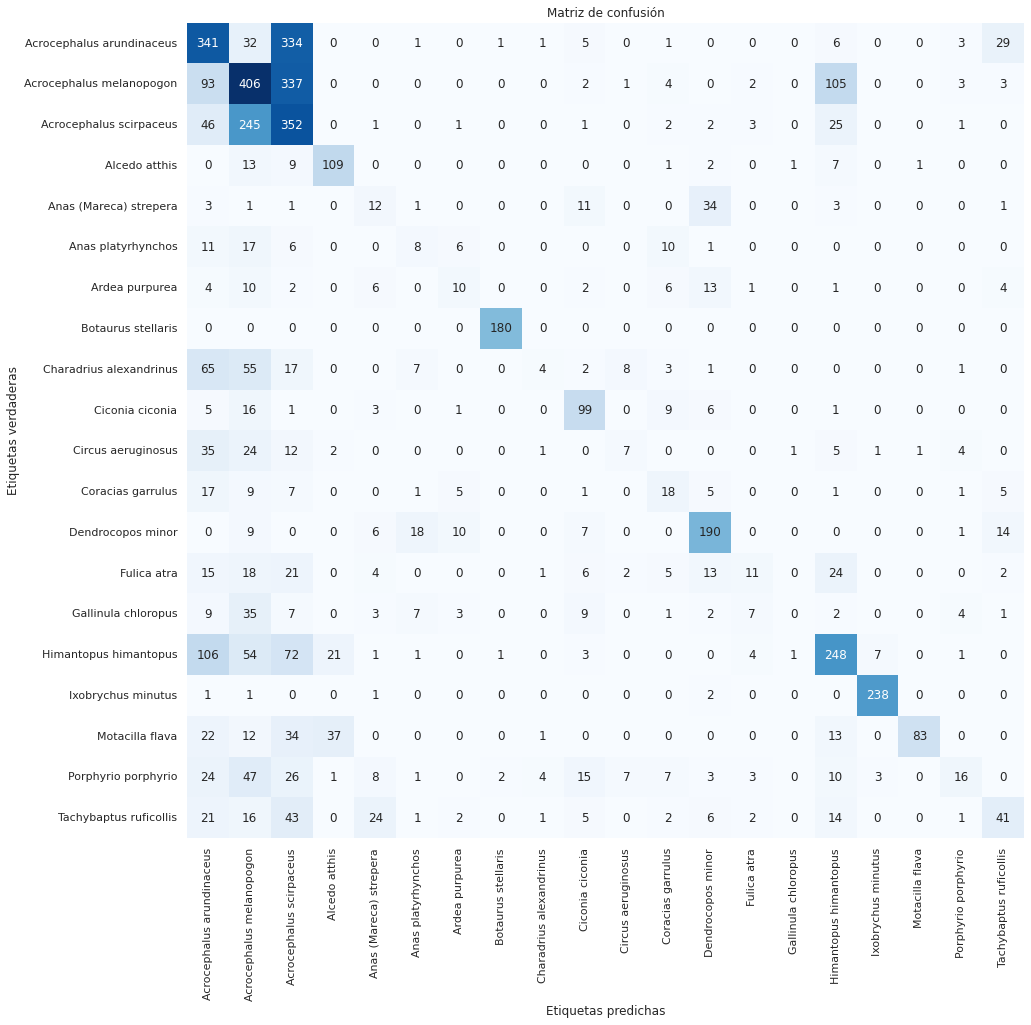

In [ ]:
class_labels=['Acrocephalus arundinaceus','Acrocephalus melanopogon','Acrocephalus scirpaceus'
,'Alcedo atthis','Anas (Mareca) strepera','Anas platyrhynchos','Ardea purpurea','Botaurus stellaris'
,'Charadrius alexandrinus','Ciconia ciconia','Circus aeruginosus','Coracias garrulus','Dendrocopos minor'
,'Fulica atra','Gallinula chloropus','Himantopus himantopus','Ixobrychus minutus','Motacilla flava','Porphyrio porphyrio','Tachybaptus ruficollis']

# Crea la matriz de confusión
confusion = confusion_matrix(y_test, y_test_rf)

# Crea el gráfico de la matriz de confusión
plt.figure(figsize=(15, 15))
sns.set(font_scale=1)
sns.heatmap(confusion, annot=True, fmt='d', cmap="Blues", cbar=False)
# Establecer las etiquetas de los ejes
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks + 0.5, class_labels, rotation=90)
plt.yticks(tick_marks + 0.5, class_labels, rotation=0)

# Añadir etiquetas a los ejes
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de confusión')


plt.show()

###Modelo de Decision Tree

In [ ]:
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_test_dtc = model_DTC.predict(X_test)

In [ ]:
print("Accuracy Score:", round(accuracy_score(y_test, y_test_dtc),2))

Accuracy Score: 0.35


In [ ]:
print(classification_report(y_test_dtc,y_test))

                           precision    recall  f1-score   support

Acrocephalus arundinaceus       0.32      0.28      0.29       509
 Acrocephalus melanopogon       0.31      0.37      0.34       488
  Acrocephalus scirpaceus       0.45      0.48      0.46       664
            Alcedo atthis       0.82      0.35      0.49        91
   Anas (Mareca) strepera       0.23      0.31      0.27        68
       Anas platyrhynchos       0.04      0.04      0.04        50
           Ardea purpurea       0.21      0.23      0.22        35
       Botaurus stellaris       0.84      0.88      0.86        83
  Charadrius alexandrinus       0.19      0.19      0.19        67
          Ciconia ciconia       0.13      0.12      0.13       107
       Circus aeruginosus       0.23      0.17      0.20        88
        Coracias garrulus       0.30      0.09      0.14        64
        Dendrocopos minor       0.45      0.45      0.45       137
              Fulica atra       0.22      0.27      0.24     

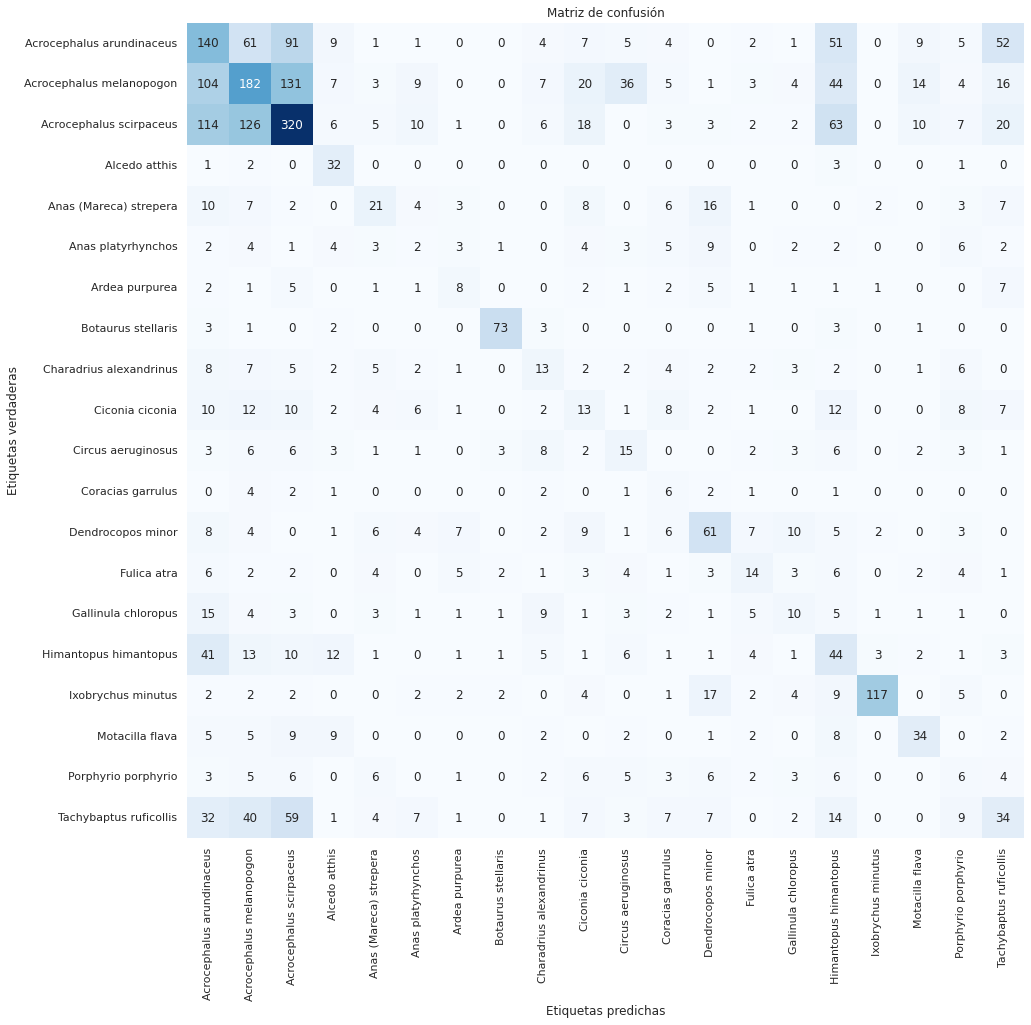

In [ ]:
class_labels=['Acrocephalus arundinaceus','Acrocephalus melanopogon','Acrocephalus scirpaceus'
,'Alcedo atthis','Anas (Mareca) strepera','Anas platyrhynchos','Ardea purpurea','Botaurus stellaris'
,'Charadrius alexandrinus','Ciconia ciconia','Circus aeruginosus','Coracias garrulus','Dendrocopos minor'
,'Fulica atra','Gallinula chloropus','Himantopus himantopus','Ixobrychus minutus','Motacilla flava','Porphyrio porphyrio','Tachybaptus ruficollis']

# Crea la matriz de confusión
confusion = confusion_matrix(y_test, y_test_dtc)

# Crea el gráfico de la matriz de confusión
plt.figure(figsize=(15, 15))
sns.set(font_scale=1)
sns.heatmap(confusion, annot=True, fmt='d', cmap="Blues", cbar=False)
# Establecer las etiquetas de los ejes
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks + 0.5, class_labels, rotation=90)
plt.yticks(tick_marks + 0.5, class_labels, rotation=0)

# Añadir etiquetas a los ejes
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de confusión')


plt.show()

###Modelo de Naive Bayes

In [ ]:
model_NB=GaussianNB()
model_NB.fit(X_train,y_train)

GaussianNB()

In [ ]:
y_test_nb=model_NB.predict(X_test)

In [ ]:
print("Accuracy Score:", round(accuracy_score(y_test, y_test_nb),2))

Accuracy Score: 0.34


In [ ]:
print(classification_report(y_test_nb,y_test))

                           precision    recall  f1-score   support

Acrocephalus arundinaceus       0.06      0.42      0.11        66
 Acrocephalus melanopogon       0.31      0.40      0.35       467
  Acrocephalus scirpaceus       0.36      0.46      0.40       504
            Alcedo atthis       0.60      0.87      0.71       138
   Anas (Mareca) strepera       0.01      0.14      0.01         7
       Anas platyrhynchos       0.06      0.07      0.06        30
           Ardea purpurea       0.30      0.13      0.18       153
       Botaurus stellaris       0.74      0.59      0.66       237
  Charadrius alexandrinus       0.33      0.14      0.19       280
          Ciconia ciconia       0.46      0.40      0.43       131
       Circus aeruginosus       0.07      0.14      0.10        64
        Coracias garrulus       0.67      0.27      0.38       277
        Dendrocopos minor       0.40      0.59      0.48       267
              Fulica atra       0.31      0.10      0.16     

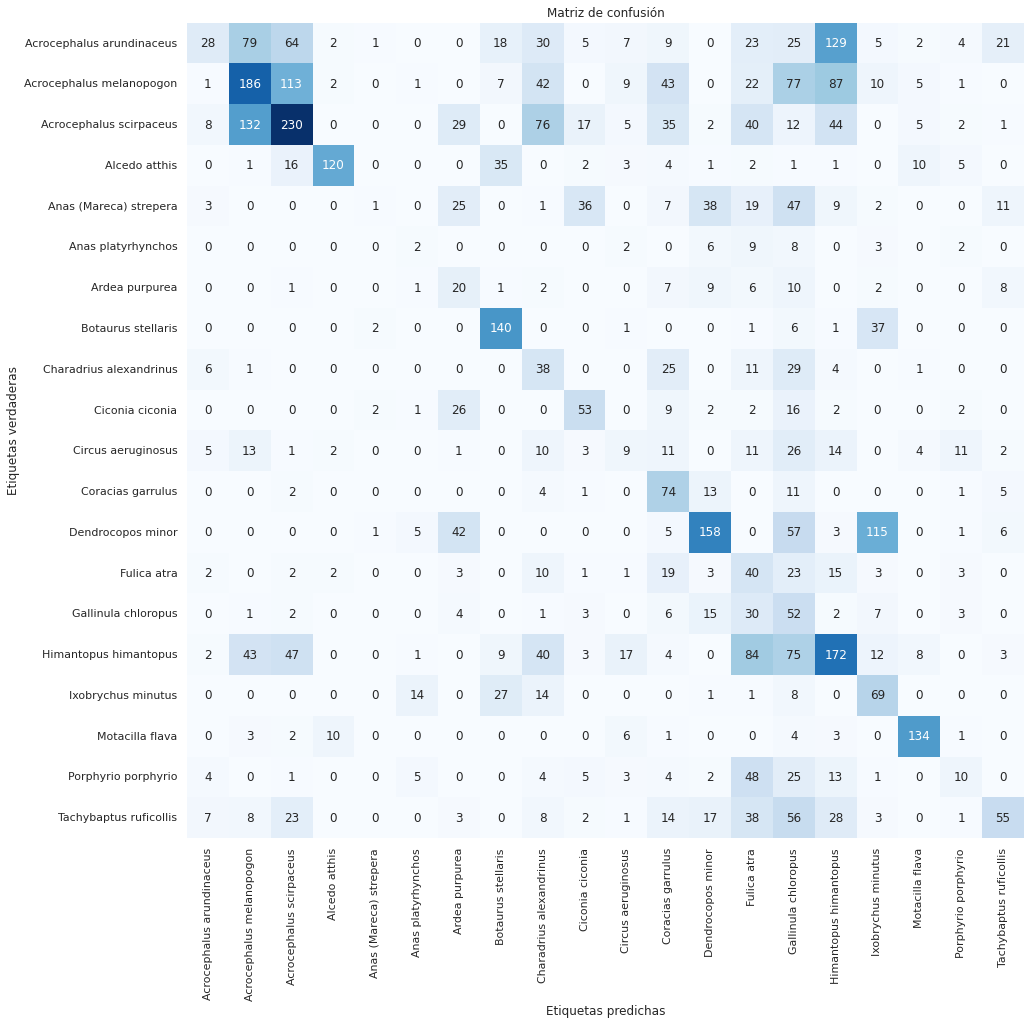

In [ ]:
class_labels=['Acrocephalus arundinaceus','Acrocephalus melanopogon','Acrocephalus scirpaceus'
,'Alcedo atthis','Anas (Mareca) strepera','Anas platyrhynchos','Ardea purpurea','Botaurus stellaris'
,'Charadrius alexandrinus','Ciconia ciconia','Circus aeruginosus','Coracias garrulus','Dendrocopos minor'
,'Fulica atra','Gallinula chloropus','Himantopus himantopus','Ixobrychus minutus','Motacilla flava','Porphyrio porphyrio','Tachybaptus ruficollis']

# Crea la matriz de confusión
confusion = confusion_matrix(y_test, y_test_nb)

# Crea el gráfico de la matriz de confusión
plt.figure(figsize=(15, 15))
sns.set(font_scale=1)
sns.heatmap(confusion, annot=True, fmt='d', cmap="Blues", cbar=False)
# Establecer las etiquetas de los ejes
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks + 0.5, class_labels, rotation=90)
plt.yticks(tick_marks + 0.5, class_labels, rotation=0)

# Añadir etiquetas a los ejes
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de confusión')


plt.show()

###Modelo de KNN

In [ ]:
model_knn=KNeighborsClassifier(n_neighbors=7)
model_knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
y_test_knn=model_knn.predict(X_test)

In [ ]:
print("Accuracy Score:", round(accuracy_score(y_test, y_test_knn),2))

Accuracy Score: 0.4


In [ ]:
print(classification_report(y_test_knn,y_test))

                           precision    recall  f1-score   support

Acrocephalus arundinaceus       0.47      0.27      0.35       769
 Acrocephalus melanopogon       0.51      0.31      0.39       978
  Acrocephalus scirpaceus       0.44      0.54      0.49       526
            Alcedo atthis       0.89      0.46      0.61       384
   Anas (Mareca) strepera       0.01      0.67      0.02         3
       Anas platyrhynchos       0.16      0.03      0.06       144
           Ardea purpurea       0.12      0.29      0.17        28
       Botaurus stellaris       0.87      0.47      0.61       348
  Charadrius alexandrinus       0.11      0.13      0.12       100
          Ciconia ciconia       0.67      0.32      0.44       237
       Circus aeruginosus       0.02      0.07      0.04        41
        Coracias garrulus       0.03      0.60      0.05         5
        Dendrocopos minor       0.58      0.83      0.68       271
              Fulica atra       0.15      0.53      0.23     

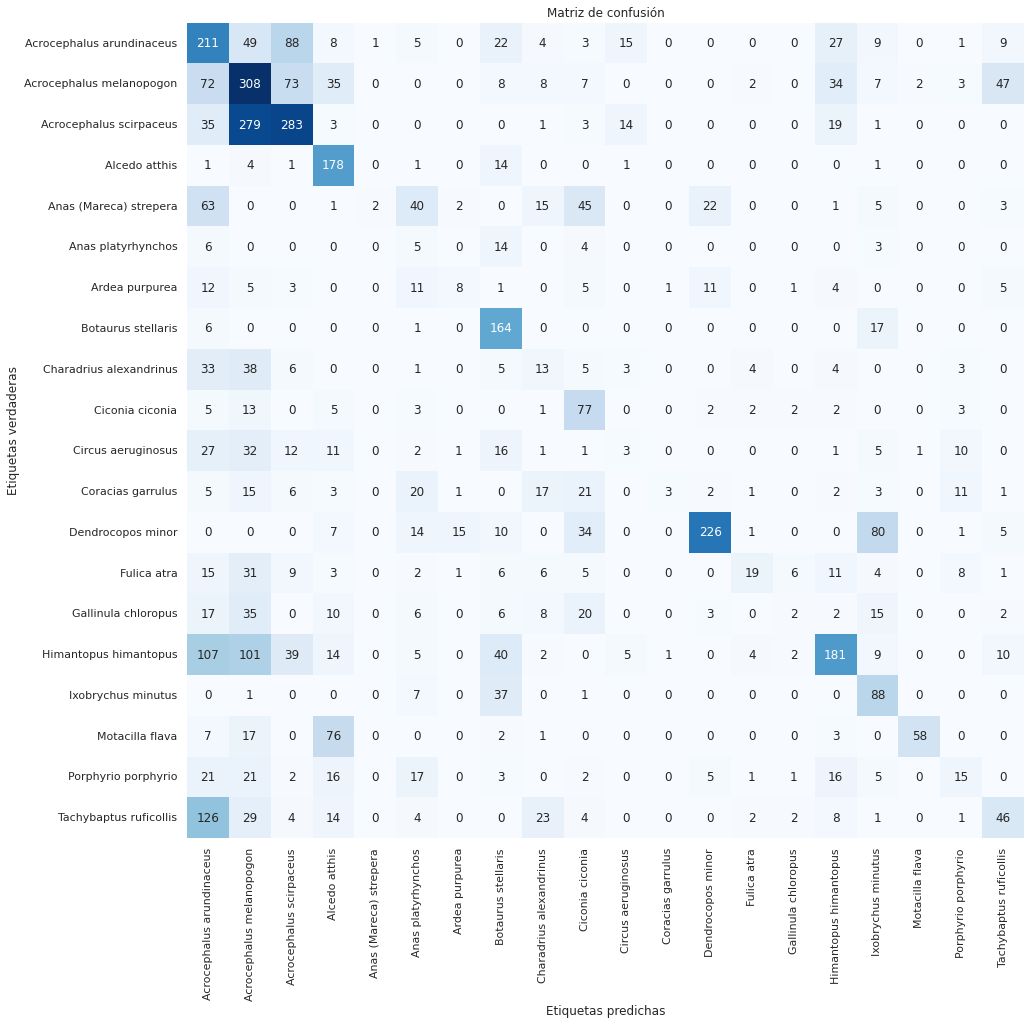

In [ ]:
class_labels=['Acrocephalus arundinaceus','Acrocephalus melanopogon','Acrocephalus scirpaceus'
,'Alcedo atthis','Anas (Mareca) strepera','Anas platyrhynchos','Ardea purpurea','Botaurus stellaris'
,'Charadrius alexandrinus','Ciconia ciconia','Circus aeruginosus','Coracias garrulus','Dendrocopos minor'
,'Fulica atra','Gallinula chloropus','Himantopus himantopus','Ixobrychus minutus','Motacilla flava','Porphyrio porphyrio','Tachybaptus ruficollis']

# Crea la matriz de confusión
confusion = confusion_matrix(y_test, y_test_knn)

# Crea el gráfico de la matriz de confusión
plt.figure(figsize=(15, 15))
sns.set(font_scale=1)
sns.heatmap(confusion, annot=True, fmt='d', cmap="Blues", cbar=False)
# Establecer las etiquetas de los ejes
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks + 0.5, class_labels, rotation=90)
plt.yticks(tick_marks + 0.5, class_labels, rotation=0)

# Añadir etiquetas a los ejes
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de confusión')


plt.show()

##Algoritmos de Deep Learning

###Modelo convolucional CNN

In [ ]:
# Definimos los parámetros del modelo
input_shape = X_train_2.shape[1:]
num_classes = 20

# Creamos el modelo
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=input_shape))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(num_classes, activation="softmax"))

In [ ]:
# Compilamos el modelo
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_2, y_train_2, epochs=10, batch_size=32)


Epoch 1/10
387/387 [==============================] - 26s 37ms/step - loss: 1.4374 - accuracy: 0.5534
Epoch 2/10
387/387 [==============================] - 14s 36ms/step - loss: 0.7185 - accuracy: 0.7748
Epoch 3/10
387/387 [==============================] - 14s 37ms/step - loss: 0.4288 - accuracy: 0.8662
Epoch 4/10
387/387 [==============================] - 14s 37ms/step - loss: 0.2583 - accuracy: 0.9177
Epoch 5/10
387/387 [==============================] - 14s 37ms/step - loss: 0.1521 - accuracy: 0.9513
Epoch 6/10
387/387 [==============================] - 14s 37ms/step - loss: 0.0971 - accuracy: 0.9709
Epoch 7/10
387/387 [==============================] - 14s 37ms/step - loss: 0.0536 - accuracy: 0.9845
Epoch 8/10
387/387 [==============================] - 14s 37ms/step - loss: 0.0475 - accuracy: 0.9860
Epoch 9/10
387/387 [==============================] - 14s 37ms/step - loss: 0.0394 - accuracy: 0.9878
Epoch 10/10
387/387 [==============================] - 14s 37ms/step - loss: 0.025

In [ ]:
predictions = model.predict(X_test_2)

157/157 [==============================] - 3s 12ms/step


In [ ]:
label_predictions = np.argmax(predictions,axis = 1)

In [ ]:
accuracy = model.evaluate(X_test_2, y_test_2)
print(accuracy[1], "Accuracy en Test",)

157/157 [==============================] - 2s 12ms/step - loss: 1.9569 - accuracy: 0.6887
0.6886942386627197 Accuracy en Test


In [ ]:
print(classification_report(y_test_2, label_predictions))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71       847
           1       0.48      0.40      0.43       640
           2       0.53      0.72      0.61       769
           3       0.91      0.94      0.92       203
           4       0.85      0.19      0.32       201
           5       0.45      0.75      0.56        36
           6       0.59      0.63      0.61        65
           7       0.99      1.00      1.00       214
           8       0.67      0.59      0.63        90
           9       0.91      0.94      0.93       208
          10       0.82      0.37      0.51       123
          11       0.43      0.56      0.49        81
          12       0.95      0.89      0.92       336
          13       0.76      0.70      0.73        96
          14       0.62      0.33      0.43        98
          15       0.70      0.72      0.71       415
          16       0.57      0.93      0.71        71
          17       0.88    

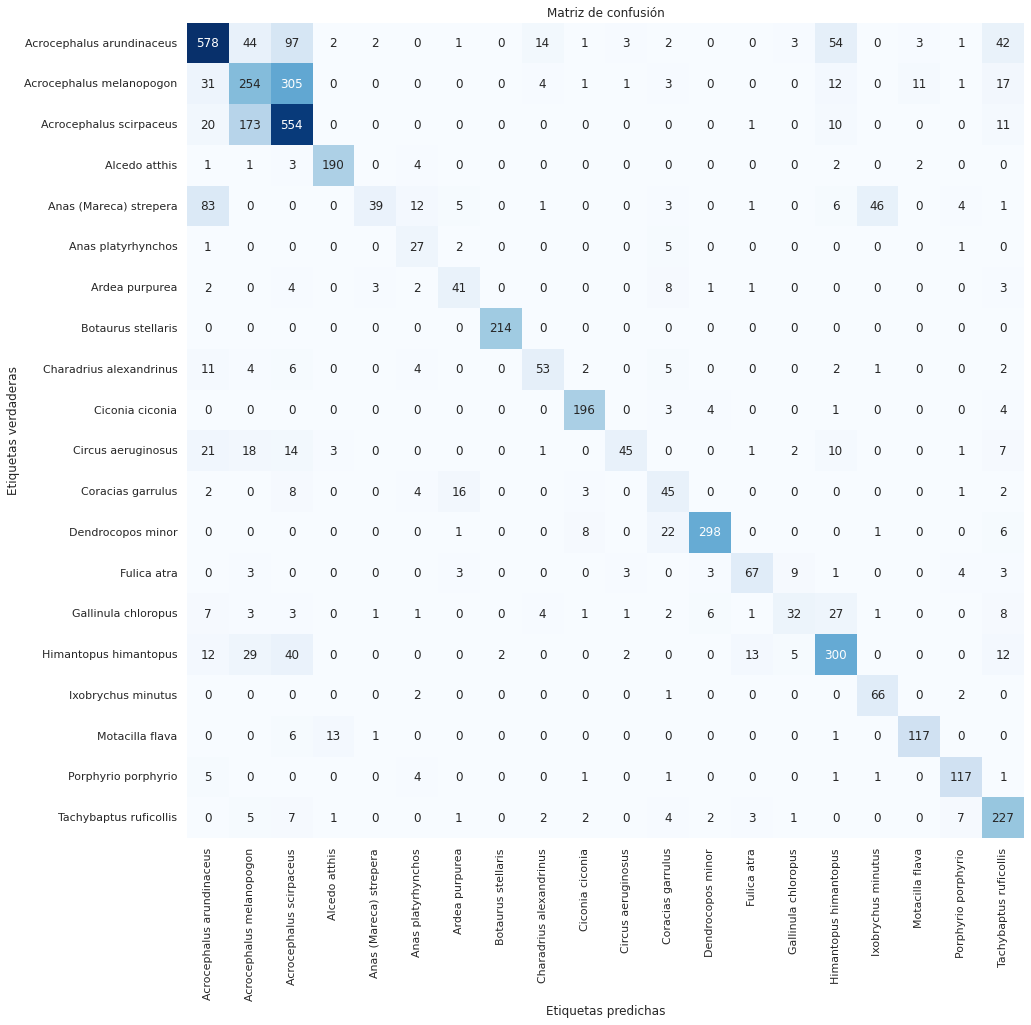

In [ ]:
class_labels=['Acrocephalus arundinaceus','Acrocephalus melanopogon','Acrocephalus scirpaceus'
,'Alcedo atthis','Anas (Mareca) strepera','Anas platyrhynchos','Ardea purpurea','Botaurus stellaris'
,'Charadrius alexandrinus','Ciconia ciconia','Circus aeruginosus','Coracias garrulus','Dendrocopos minor'
,'Fulica atra','Gallinula chloropus','Himantopus himantopus','Ixobrychus minutus','Motacilla flava','Porphyrio porphyrio','Tachybaptus ruficollis']

# Crea la matriz de confusión
confusion = confusion_matrix(y_test_2, label_predictions)

# Crea el gráfico de la matriz de confusión
plt.figure(figsize=(15, 15))
sns.set(font_scale=1)
sns.heatmap(confusion, annot=True,  fmt='d',cmap="Blues", cbar=False)
# Establecer las etiquetas de los ejes
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks + 0.5, class_labels, rotation=90)
plt.yticks(tick_marks + 0.5, class_labels, rotation=0)

# Añadir etiquetas a los ejes
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de confusión')


plt.show()

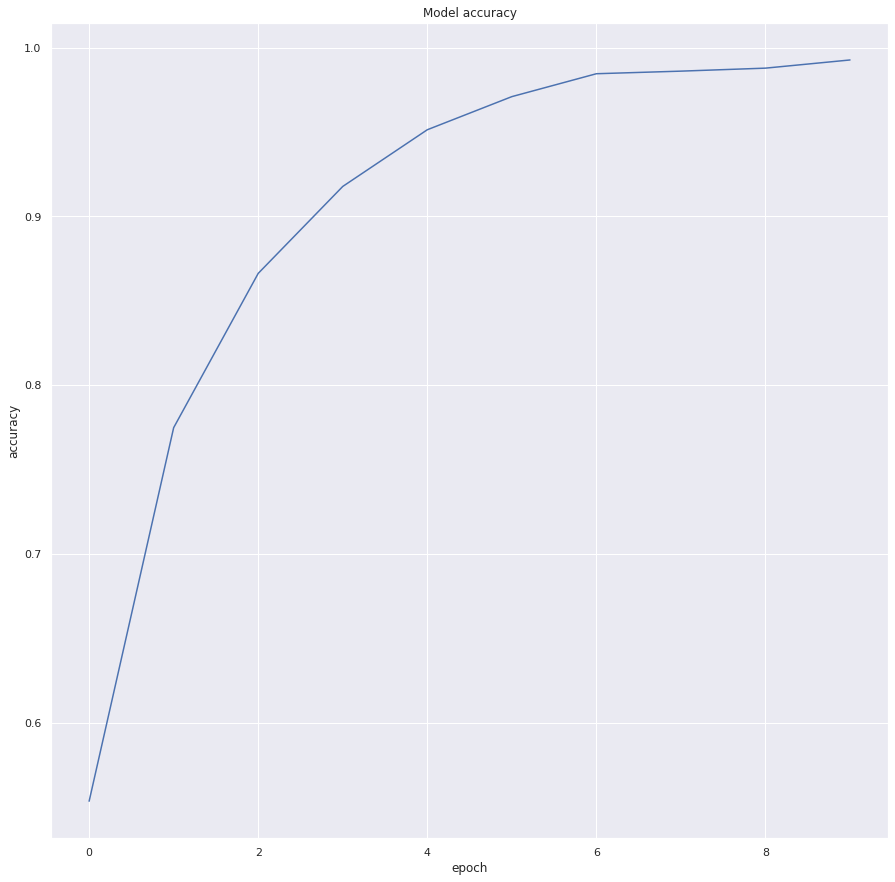

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

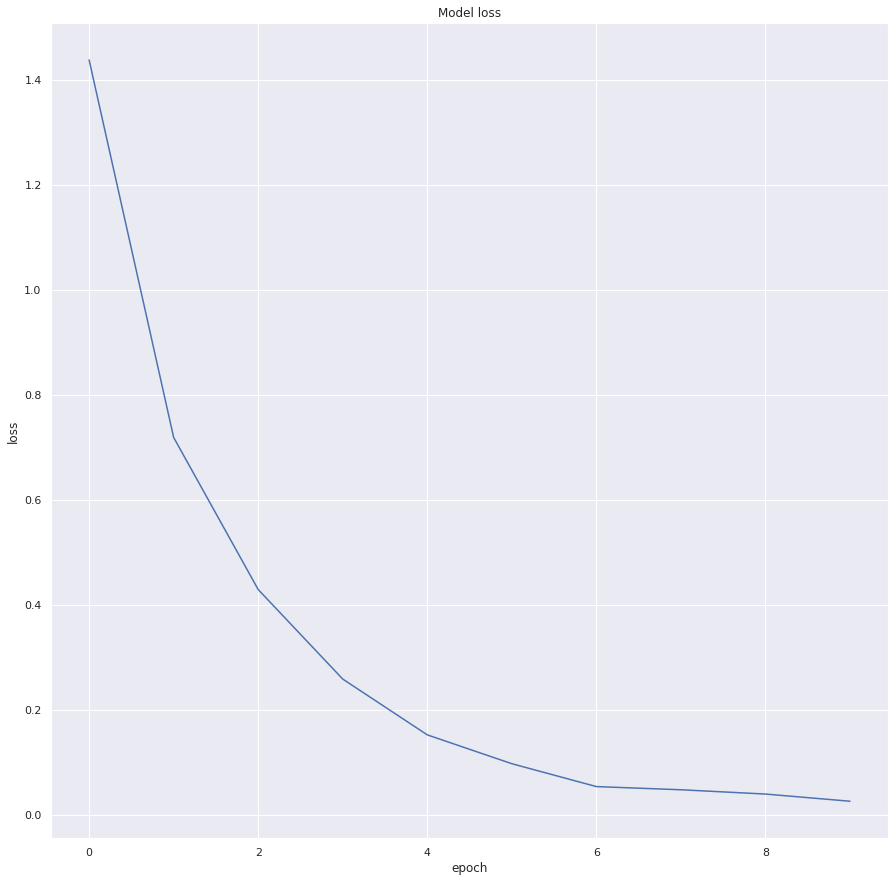

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()